# Testing various methods of data transformation

In [1]:
import glob
import os
import sys

sys.path.append('..')

In [2]:
import torch
import torch.nn as nn

import numpy as np
import numpy.ma as ma
import matplotlib.pyplot as plt

from astropy.io import fits

from tqdm import tqdm

from inverse_problem import HinodeME
from inverse_problem import SpectrumDataset, PregenSpectrumDataset, make_loader
from inverse_problem.nn_inversion.posthoc import compute_metrics, open_param_file, plot_params, plot_pred_vs_refer, plot_analysis_hist2d, plot_hist_params
from inverse_problem.nn_inversion.posthoc import open_spectrum_data, real_spectra, plot_spectrum, plot_model_spectrum, read_spectrum_for_refer
from inverse_problem.nn_inversion.transforms import normalize_output, inverse_transformation

from inverse_problem.nn_inversion.model_pi_mlp_conv import PIMLPConvNet
from inverse_problem.nn_inversion import conv1d_transform_rescale, normalize_spectrum


%matplotlib inline
%load_ext autoreload
%autoreload 2

## Data

In [3]:
filename = '../data/parameters_base.fits'
params = fits.open(filename)[0].data

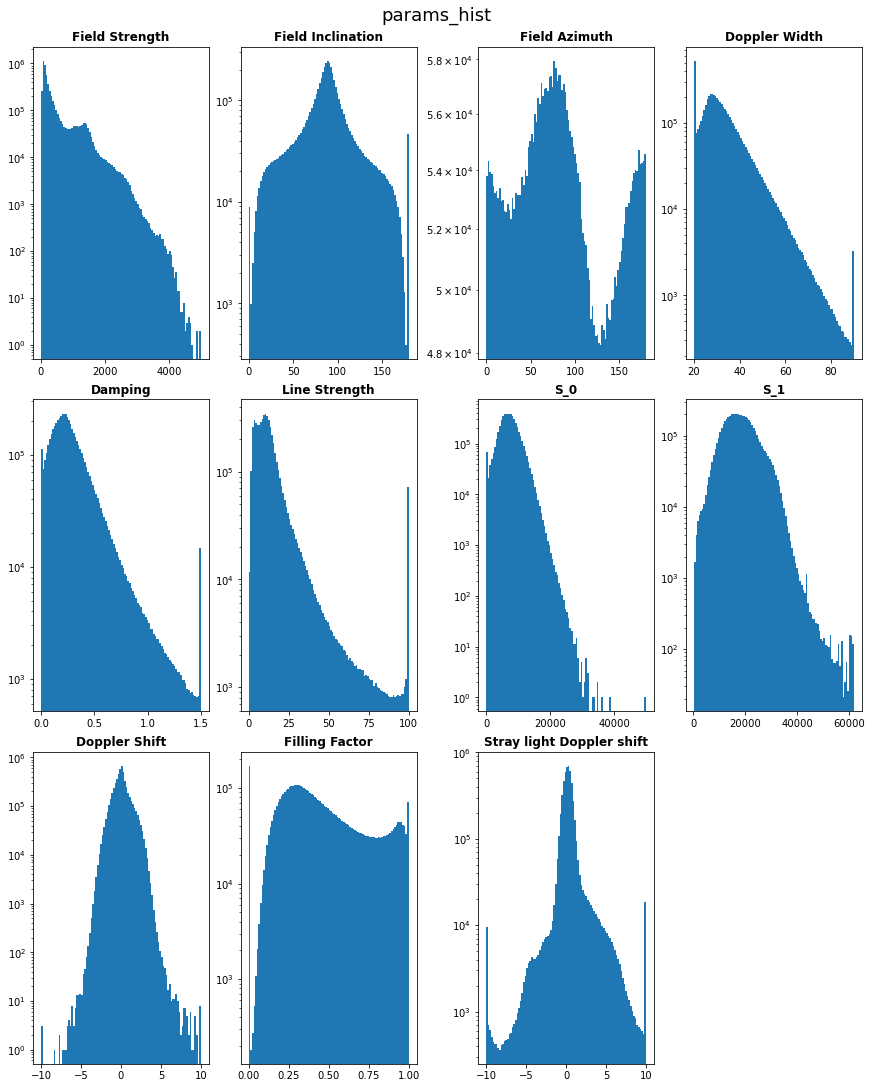

In [4]:
plot_hist_params(params)

### Data filt

In [5]:
def create_mask(pars_arr):
    max_par_values = np.array([par_arr.max() for par_arr in pars_arr.T])
    min_par_values = np.array([par_arr.min() for par_arr in pars_arr.T])

    bool_arr = (min_par_values + 1e-3 < pars_arr) & (pars_arr < max_par_values - 1e-3)
    return bool_arr

In [6]:
mask = create_mask(params)
rows_mask = np.all(mask, axis=1)

filtered_params = params[rows_mask, :]

## Min-Max Scaling

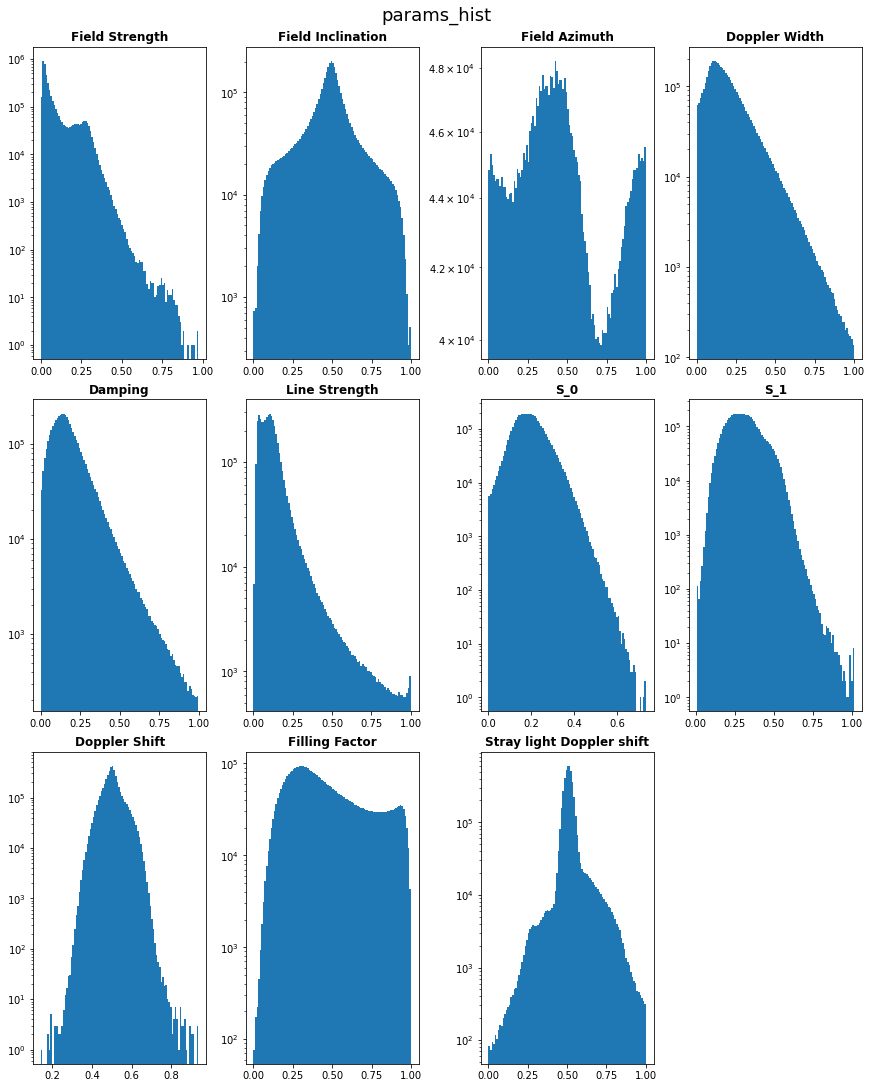

In [39]:
plot_hist_params(normalize_output(filtered_params, logB=False, angle_transformation=False))

## Quantile Transform

In [7]:
from sklearn.preprocessing import QuantileTransformer

In [8]:
qt = QuantileTransformer(random_state=0, output_distribution='normal')
params_qt = qt.fit_transform(filtered_params.reshape(-1, 11))

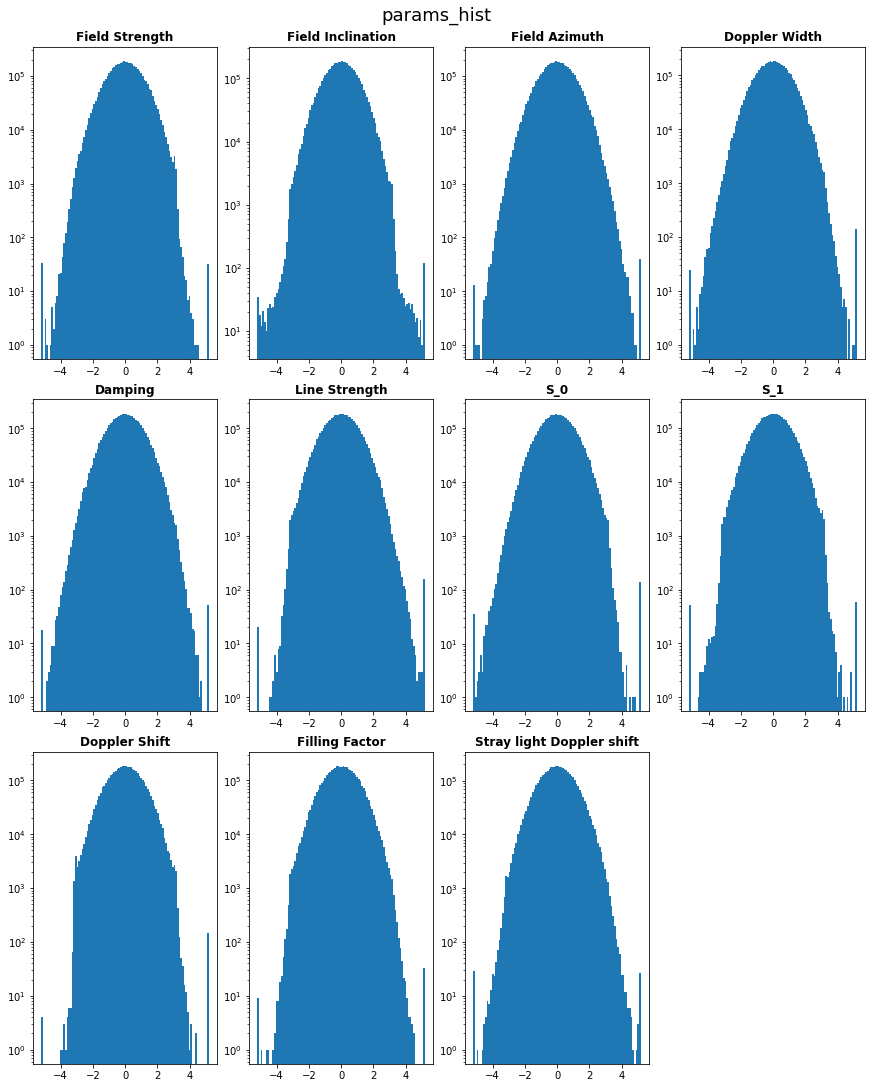

In [9]:
plot_hist_params(params_qt)

In [10]:
np.sum(params_qt == params_qt.max(), axis=0) + np.sum(params_qt == params_qt.min(), axis=0)

array([ 66, 146,  52, 164,  68, 175, 173, 112, 152,  42,  56])

## Power Transform

In [16]:
from sklearn.preprocessing import PowerTransformer

In [17]:
pt = PowerTransformer()
tr_data = pt.fit_transform(filtered_params)

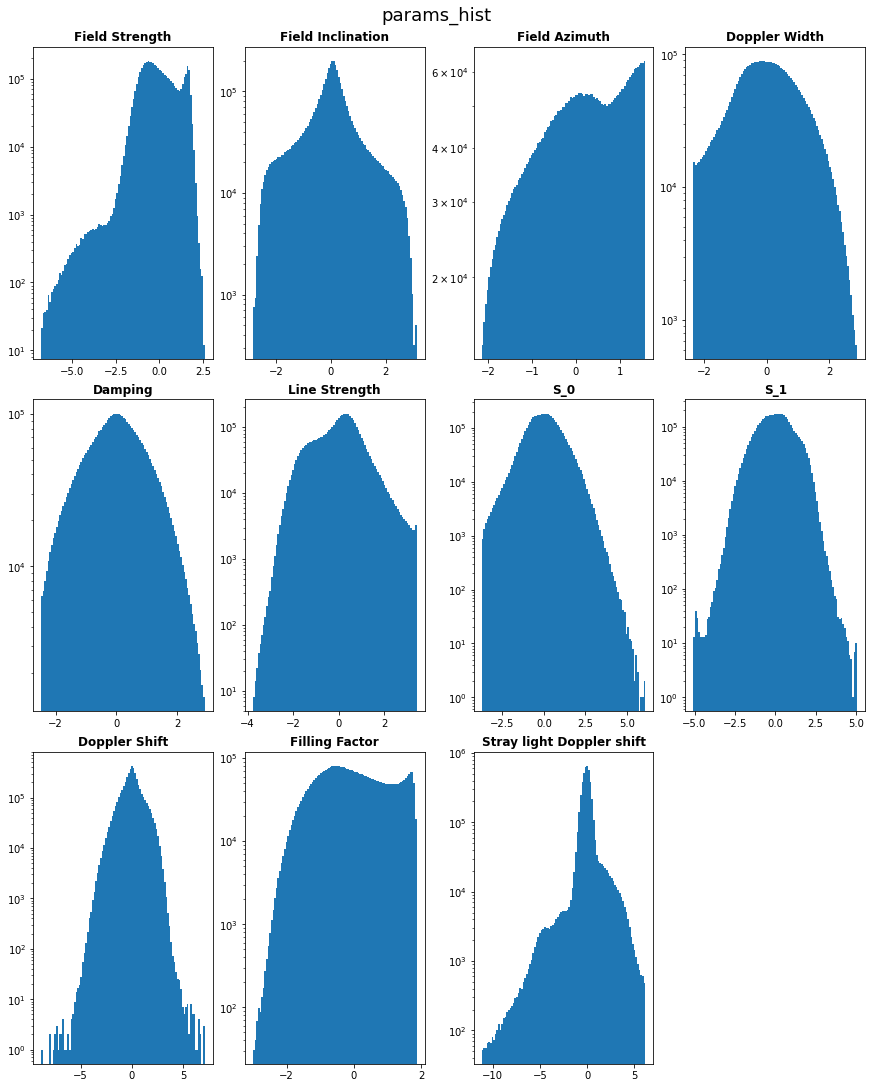

In [21]:
norm_data = normalize_output(filtered_params, logB=False, angle_transformation=False, PowerTransformer=pt)
plot_hist_params(norm_data)

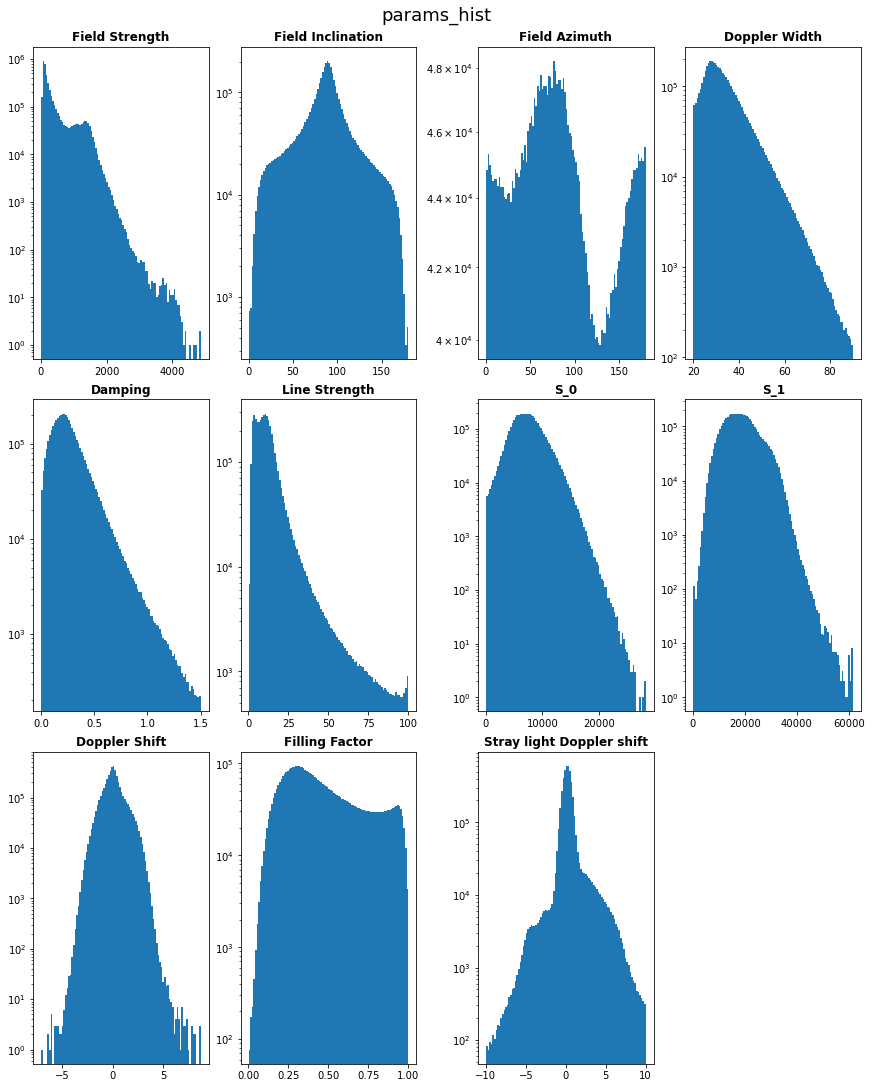

In [22]:
data_inv = pt.inverse_transform(norm_data)
plot_hist_params(data_inv)